In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from dwave.system.samplers import DWaveSampler
import matplotlib.pyplot as plt
# Magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
import matplotlib.pyplot as plt
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite,FixedEmbeddingComposite
from tqdm import tqdm
import neal
import pandas as pd

In [2]:
import dimod
from dwave.system import LeapHybridSampler

In [3]:
class excutor_simul():
    def __init__(self,interval,num_shots):
        self.num_shots = num_shots
        self.interval = interval
    def Test(self,BoundaryCondition,L,J1):
        responses = []
        if BoundaryCondition == "PBC":
            print("PBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H = self.__PBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                long_time = sampler.properties['annealing_time_range'][1]
                long_time = int(long_time/4)
                sampler = FixedEmbeddingComposite(sampler,embedding = self.embedding)
                sampler.sample(H)
                response = sampler.sample(H,num_reads = self.num_shots,annealing_time = long_time,programming_thermalization = pt,chain_strength=15)
                responses.append(response)
        
        else:
            responses = []
            print("OBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H2 = self.__OBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                long_time = sampler.properties['annealing_time_range'][1]
                long_time = int(long_time/4)
                sampler = neal.SimulatedAnnealingSampler()
                response = sampler.sample(H2,num_reads = self.num_shots,answer_mode = 'raw',beta_range = [0.1,0.5])
                responses.append(response)
        return responses

    def __OBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # - ,\
        num_idx2 = num[L-1,:] # |
        num_idx3 = num[:,0] # /
        for i in range(L**2):
            if i in num_idx1:
                continue
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                continue
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx2: #interaction with rightdiagonal factor
                continue
            elif i in num_idx1:
                continue
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3: #interaction with leftdiagonal factor
                continue
            elif i in num_idx2:
                continue
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H      
    
    def __PBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # ##마지막 열
        num_idx2 = num[L-1,:] # ##마지막행
        num_idx3 = num[:,0] #첫번째 열
        for i in range(L**2):
            if i in num_idx1:
                quadratic[(i-L+1,i)] = -J1
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                quadratic[(i-L**2+L,i)] = -J1
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx1 and i in num_idx2: #interaction with rightdiagonal factor
                quadratic[(i,0)] = J2
            elif i in num_idx2 and not(i in num_idx1):
                quadratic[(i,i-L**2+L+1)] = J2
            elif i in num_idx1 and not(i in num_idx2):
                quadratic[(i,i+1)] = J2
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3 and i in num_idx2 : #interaction with leftdiagonal factor
                quadratic[(i,L-1)] = J2
            elif i in num_idx2 and not(i in num_idx3):
                quadratic[(i,i-L**2+L-1)] = J2
            elif i in num_idx3 :
                quadratic[(i,i+2*L-1)] = J2
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H
            
        
        

In [4]:
class excutor_tc():
    def __init__(self,num_shots,interval,embedding):
        self.num_shots = num_shots
        self.interval = interval
        self.embedding = embedding
    def Test(self,BoundaryCondition,L,J1):
        responses = []
        if BoundaryCondition == "PBC":
            print("PBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H = self.__PBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                long_time = sampler.properties['annealing_time_range'][1]
                long_time = int(long_time)
                sampler = FixedEmbeddingComposite(sampler,embedding = self.embedding)
                sampler.sample(H)
                pt = int(sampler.child.properties['programming_thermalization_range'][1])
                response = sampler.sample(H,num_reads = self.num_shots,annealing_time = long_time,programming_thermalization = pt,chain_strength=15)
                responses.append(response)
        
        else:
            responses = []
            print("OBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H2 = self.__OBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                long_time = sampler.properties['annealing_time_range'][1]
                long_time = int(long_time)/3
                sampler = FixedEmbeddingComposite(sampler,embedding = self.embedding)
                sampler.sample(H2)
                response = sampler.sample(H2,num_reads = self.num_shots,annealing_time = long_time,chain_strength=15)
                responses.append(response)
        return responses

    def __OBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # - ,\
        num_idx2 = num[L-1,:] # |
        num_idx3 = num[:,0] # /
        for i in range(L**2):
            if i in num_idx1:
                continue
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                continue
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx2: #interaction with rightdiagonal factor
                continue
            elif i in num_idx1:
                continue
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3: #interaction with leftdiagonal factor
                continue
            elif i in num_idx2:
                continue
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H      
    
    def __PBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # ##마지막 열
        num_idx2 = num[L-1,:] # ##마지막행
        num_idx3 = num[:,0] #첫번째 열
        for i in range(L**2):
            if i in num_idx1:
                quadratic[(i-L+1,i)] = -J1
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                quadratic[(i-L**2+L,i)] = -J1
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx1 and i in num_idx2: #interaction with rightdiagonal factor
                quadratic[(i,0)] = J2
            elif i in num_idx2 and not(i in num_idx1):
                quadratic[(i,i-L**2+L+1)] = J2
            elif i in num_idx1 and not(i in num_idx2):
                quadratic[(i,i+1)] = J2
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3 and i in num_idx2 : #interaction with leftdiagonal factor
                quadratic[(i,L-1)] = J2
            elif i in num_idx2 and not(i in num_idx3):
                quadratic[(i,i-L**2+L-1)] = J2
            elif i in num_idx3 :
                quadratic[(i,i+2*L-1)] = J2
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H
            
        
        

In [5]:
excutor_tc

__main__.excutor_tc

In [6]:
class excutor_real_raw(): ##날것
    def __init__(self,num_shots,interval):
        self.num_shots = num_shots
        self.interval = interval
    def Test(self,BoundaryCondition,L,J1):
        responses = []
        if BoundaryCondition == "PBC":
            print("PBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H = self.__PBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                long_time = sampler.properties['annealing_time_range'][1]
                long_time = int(long_time)
                sampler = FixedEmbeddingComposite(sampler,embedding = self.embedding)
                sampler.sample(H)
                pt = int(sampler.child.properties['programming_thermalization_range'][1])
                response = sampler.sample(H,num_reads = self.num_shots,annealing_time = long_time,programming_thermalization = pt,chain_strength=15)
                responses.append(response)
        
        else:
            responses = []
            print("OBC Processing L = ",L)
            for J2 in tqdm(self.interval):
                H2 = self.__OBC_hamiltonian(L,J1,J2)
                sampler = DWaveSampler()
                sampler = EmbeddingComposite(sampler)
                response = sampler.sample(H2,num_reads = self.num_shots)
                responses.append(response)
        return responses

    def __OBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # - ,\
        num_idx2 = num[L-1,:] # |
        num_idx3 = num[:,0] # /
        for i in range(L**2):
            if i in num_idx1:
                continue
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                continue
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx2: #interaction with rightdiagonal factor
                continue
            elif i in num_idx1:
                continue
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3: #interaction with leftdiagonal factor
                continue
            elif i in num_idx2:
                continue
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H      
    
    def __PBC_hamiltonian(self,L,J1,J2):
        linear = {}
        quadratic = {}
        num = np.arange(L**2).reshape(L,L)
        num_idx1 = num[:,L-1] # ##마지막 열
        num_idx2 = num[L-1,:] # ##마지막행
        num_idx3 = num[:,0] #첫번째 열
        for i in range(L**2):
            if i in num_idx1:
                quadratic[(i-L+1,i)] = -J1
            else:
                quadratic[(i,i+1)] = -J1 #interaction with rightside factor

            if i in num_idx2:
                quadratic[(i-L**2+L,i)] = -J1
            else :
                quadratic[(i,i+L)] = -J1 #interaction with downside factor 

            if i in num_idx1 and i in num_idx2: #interaction with rightdiagonal factor
                quadratic[(i,0)] = J2
            elif i in num_idx2 and not(i in num_idx1):
                quadratic[(i,i-L**2+L+1)] = J2
            elif i in num_idx1 and not(i in num_idx2):
                quadratic[(i,i+1)] = J2
            else:
                quadratic[(i,i+L+1)] = J2

            if i in num_idx3 and i in num_idx2 : #interaction with leftdiagonal factor
                quadratic[(i,L-1)] = J2
            elif i in num_idx2 and not(i in num_idx3):
                quadratic[(i,i-L**2+L-1)] = J2
            elif i in num_idx3 :
                quadratic[(i,i+2*L-1)] = J2
            else :
                quadratic[i,i+L-1] = J2
        H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype = 'SPIN')
        return H
            
        
        

In [7]:
class go_pandas():
    pd.set_option('mode.chained_assignment','raise')
    pd.set_option('mode.chained_assignment','warn')
    pd.set_option('mode.chained_assignment',None)
    def __init__(self,response,interval,L):
        self.response = response
        self.interval = interval
        self.L = L
    def to_pandas(self):
        response = self.response
        interval = self.interval
        L = self.L
        BC = ['PBC','OBC']
        response_pandas = {x: [] for x in BC}
        len_interval = len(self.interval)
        for bc in BC:
            for i in range(len_interval):
                response_pandas[bc].append(self.response[bc][i].aggregate().to_pandas_dataframe())
        len_interval = len(interval)
        BC = ['PBC','OBC']
        for bc in BC:
            print(f'Processing for {bc}')
            for i in tqdm(range(len_interval)):
                response_pandas[bc][i]['Mag'] = 0.0
                response_pandas[bc][i]['Ratio'] = 0.0
                response_pandas[bc][i]['real_energy'] = 0.0
                num_occ = len(response_pandas[bc][i]['num_occurrences'])
                for j in range(num_occ):
                    ene = 0.0
                    response_pandas[bc][i]['Mag'].loc[j] = sum(response_pandas[bc][i].loc[j][0:L**2]) ##calculation Mag
                    response_pandas[bc][i]['Ratio'].loc[j] = (response_pandas[bc][i]["num_occurrences"][j]/sum(response_pandas[bc][i]["num_occurrences"]))
                    ##Energy
                    num_ising = np.array(response_pandas[bc][i].loc[j][0:L**2]).reshape(L,L)
    #                 if bc == 'PBC':
                    ene = 0.0
                response_pandas[bc][i]['Mag**2'] = response_pandas[bc][i]['Mag']**2
                response_pandas[bc][i]['Sus'] = (response_pandas[bc][i]['Mag**2'])
        return response_pandas
    def cal_more_infomation(self,J1,interval):
        response = self.response
        interval = self.interval
        L = self.L
        BC = ['PBC','OBC']
        response_pandas = {x: [] for x in BC}
        len_interval = len(self.interval)
        for bc in BC:
            for i in range(len_interval):
                response_pandas[bc].append(self.response[bc][i].aggregate().to_pandas_dataframe())
        mag_data_list = {x :[] for x in BC}
        ene_data_list = {y: [] for y in BC}
        for bc in BC:
            for j in range(len(self.interval)):
                data = response_pandas[bc][j].loc[0][0:self.L**2]
                mag_data_list[bc].append(np.abs(data.sum()))
                num_data = np.array(data).reshape(L,L)
                data_num_idx = np.arange(self.L**2).reshape(self.L,self.L)
                # 에너지,j1j2 비율
            for k,J2 in enumerate(interval):
                data = response_pandas[bc][k].loc[0][0:self.L**2]
                num_data = np.array(data).reshape(L,L)
                tot_ene =0.0
                for k in range(self.L):
                    for l in range(self.L):
                        eneJ1 = 0.0
                        eneJ2 = 0.0
                        sig = num_data[k,l]
                        if k != L-1 and l != L-1 and k != 0 and l != 0 :
                            eneJ1 += -J1*sig*num_data[(k,l-1)] -J1*sig*num_data[(k,l+1)]-J1*sig*num_data[(k+1,l)]-J1*sig*num_data[(k-1,l)]
                            eneJ2 += J2*sig*num_data[(k+1,l+1)] + J2*sig*num_data[k+1,l-1]+J2*sig*num_data[k-1,l+1]+J2*sig*num_data[k-1,l-1]
                        ##upside
                        elif l != 0 and l!= L-1 and k == 1:
                            eneJ1 += -J1*sig*num_data[k,l+1]-J1*sig*num_data[k,l-1]-J1*sig*num_data[k+1,l]
                            eneJ2 += J2*sig*num_data[k+1,l+1]+J2*sig*num_data[k+1,l-1]
                        #rightside
                        elif l == L-1 and k!= 0 and k != L-1:
                            eneJ1 += -J1*sig*num_data[k+1,l]-J1*sig*num_data[k-1,l]-J1*sig*num_data[k,l-1]
                            eneJ2 += J2*sig*num_data[k+1,l-1]+J2*sig*num_data[k-1,l-1]
                        #downside
                        elif k == L-1 and l !=0 and l!= L-1:
                            eneJ1 += -J1*sig*num_data[k-1,l]-J1*sig*num_data[k,l+1]-J1*sig*num_data[k,l-1]
                            eneJ2 += J2*sig*num_data[k-1,l+1]+ J2*sig*num_data[k-1,l-1]
                        #leftside
                        elif l == 0 and k != 0 and k!= L-1:
                            eneJ1 += -J1*sig*num_data[k,l+1]-J1*sig*num_data[k+1,l]-J1*sig*num_data[k-1,l]
                            eneJ2 += J2*sig*num_data[k+1,l+1]+J2*sig*num_data[k-1,l+1]
                        #00
                        elif l==0 and k==0:
                            eneJ1 += -J1*sig*num_data[k+1,l] - J1*sig*num_data[k,l+1]
                            eneJ2 += J2*sig*num_data[k+1,l+1]
                        ##0,L-1
                        elif l==L-1 and k==0:
                            eneJ1 += -J1*sig*num_data[k,l-1] -J1*sig*num_data[k+1,l]
                            eneJ2 += J2*sig*num_data[k+1,l-1]
                        ##L-1,L-1
                        elif l==L-1 and k == L-1:
                            eneJ1 += -J1*sig*num_data[k-1,l] -J1*sig*num_data[k,l-1]
                            eneJ2 += J2*sig*num_data[k-1,l-1]
                        ##L-1,0
                        elif l == 0 and k== L-1:
                            eneJ1 += -J1*sig*num_data[k-1,l]-J1*sig*num_data[k,l+1]
                            eneJ2 += J2*sig*num_data[k-1,l+1]
                        tot_ene += eneJ1+eneJ2
                ene_data_list[bc].append(tot_ene)
        return ene_data_list, mag_data_list

In [8]:
class ploting():
    
    def __init__(self,more_info_pandas,BC,interval,L,num_shots,J1):
        self.num_shots = num_shots
        self.more_info_pandas = more_info_pandas[BC]
        self.interval = interval
        self.J2divJ1 =  self.interval/J1
        self.L = L
        self.J1 = J1
        self.plot_interval = []
        for J2 in interval:
            val = J2/J1
            rnd = round(val,2)
            self.plot_interval.append(str(rnd))
    
    def mag_distribution(self):
        len_interval = len(self.interval)
        len_div2 = len_interval//2
        lst = ['num_occurrences','Mag']
        fig,ax = plt.subplots((len_interval)//2,2,figsize=(len_interval,len_interval*3),sharex=True,sharey=True)
        for i in range(len_interval):
            mag_num =  self.more_info_pandas[i][lst]
            mag_num['Mag'] = mag_num['Mag'].abs()
            mag_num = mag_num.groupby('Mag').sum()
            mag_num['num_occurrences'] /= self.num_shots
            mag_num = mag_num.reset_index()
            x_list = list(mag_num['Mag'])
            y_list = list(mag_num['num_occurrences'])
            ax[i//2,i%2].bar(x_list,y_list,color = 'C2',width = 2)
            ax[i//2,i%2].set_title('J2/J1 = {0:0.02f}'.format(self.J2divJ1[i]))
            ax[i//2,i%2].set_xlabel('Mag')
            ax[i//2,i%2].set_ylabel('Proability')
            
            
    def mean_mag(self):
        mag_list = []
        for i in range(len(self.interval)):
            ##가중치 고려
            mean_mag_i = ((self.more_info_pandas[i]['Mag'].abs()*self.more_info_pandas[i]['num_occurrences']).sum())/self.num_shots
            mag_list.append(mean_mag_i)
        len_mag_list = len(mag_list)
        plt.plot(np.arange(len(self.interval))+1,mag_list,'o-r')
        plt.xlabel('J2/J1')
        plt.xticks(np.arange(len(self.interval))+1,self.plot_interval)
        
    
    def most_occurrenced_mag(self):
        mo_mag_list = []
        for i in range(len(self.interval)):
            mo_mag = np.array(self.more_info_pandas[i][['num_occurrences','Mag']].abs().groupby(by='Mag').sum().reset_index().sort_values(by = 'num_occurrences',ascending = False)['Mag'])[0]
            mo_mag_list.append(mo_mag)
        plt.plot(np.arange(len(self.interval))+1,mo_mag_list/(L**2),'o-b')
        plt.xlabel('J2/J1')
        plt.xticks(self.interval,self.plot_interval)


          
    
    def sus(self):
        lst_sus = []
        for i in range(len(self.interval)):
            M2 = sum((self.more_info_pandas[i]['Mag'])**2)/self.L**2
            M = sum(self.more_info_pandas[i]['Mag']/self.L**2)
            M2/=self.num_shots
            M/=self.num_shots
            sus = (M2-M**2)
            lst_sus.append(sus)
        plt.plot(self.interval/self.J1,lst_sus,'ko-')
        plt.xlabel('J2/J1',size= 15)
        plt.ylabel(r'$\chi$',size= 15,rotation = 0 ,labelpad = 15)
        plt.xticks([0,0.5,1],[0,0.5,1])
        
    def ene(self,energy_list):
        plt.plot(self.interval/self.J1,energy_list,'ko-')
        plt.xlabel('J2/J1',size= 15)
        plt.ylabel('E',size = 15,rotation = 0,labelpad = 15)
        plt.xticks([0,0.5,1],[0,0.5,1])
        
    def mag(self,mag_list):
        mag_list = np.array(mag_list)/self.L**2
        plt.plot(self.interval/self.J1,mag_list,'ko-')
        plt.ylabel('M',size = 15,rotation = 0,labelpad = 15)
        plt.xlabel('J2/J1',size= 15)
        plt.xticks([0,0.5,1],[0,0.5,1])

    def mag_simul(self,mag_list):
        mag_list = np.array(mag_list)/self.L**2
        plt.plot(self.interval/self.J1,mag_list,'ko-')
        plt.ylabel('M',size = 15,rotation = 0,labelpad = 15)
        plt.xlabel('J2/J1',size= 15)
        plt.xticks([0,0.5,1],[0,0.5,1])

    def sus2(self,feat,label_,alpha_ = 1,marker_ = 5):
        lst_sus = []
        for i in range(len(self.interval)):
            M2 = sum((self.more_info_pandas[i]['Mag'])**2)/self.L**2
            M = sum(self.more_info_pandas[i]['Mag']/self.L**2)
            M2/=self.num_shots
            M/=self.num_shots
            sus = (M2-M**2)
            lst_sus.append(sus)
        plt.plot(self.interval/self.J1,lst_sus,feat,label = label_,markersize = marker_,alpha = alpha_)
        plt.xlabel('J2/J1',size= 15)
        plt.ylabel(r'$\chi$',size= 15,rotation = 0 ,labelpad = 15)
        plt.xticks([0,0.5,1],[0,0.5,1])

    def mag2(self,mag_list,feat,label_,alpha_=1,marker_ =5 ):
        mag_list = np.array(mag_list)/self.L**2
        plt.plot(self.interval/self.J1,mag_list,feat,label = label_,alpha = alpha_,markersize= marker_ )
        plt.ylabel('M',size = 15,rotation = 0,labelpad = 15)
        plt.xlabel('J2/J1',size= 15)
        plt.xticks([0,0.5,1],[0,0.5,1])                

In [9]:
import time

# L = 20 | numshot = 1000

## Quantum Annealing (raw)

In [15]:
start = time.time()
J1 = 10
L = 20
num_shots = 1000
J2_interval_rr = np.linspace(0,10,14)
response_rr = excutor_real_raw(num_shots,J2_interval_tc).Test('OBC',L,J1)
print("elapsed time is", time.time()- start)
print('-----------------------------------------------------')
response_rr = {x: response_rr for x in ['PBC','OBC']}
df_rr = go_pandas(response_rr,J2_interval_rr,L).to_pandas()
ene_data_rr, mag_data_rr = go_pandas(response_rr,J2_interval_rr,L).cal_more_infomation(J1,J2_interval_rr)

NameError: name 'J2_interval_tc' is not defined

In [ ]:
ploting(df_rr,'OBC',J2_interval_rr,L,num_shots,10).mag(mag_data_rr['OBC'])
plt.show()
ploting(df_rr,'OBC',J2_interval_rr,L,num_shots,10).sus()
plt.show()
ploting(df_rr,'OBC',J2_interval_rr,L,num_shots,10).ene(ene_data_rr['OBC'])

## Simulated Annealing

In [10]:
##L = 20 
L = 20
J1 = 10
num_shots = 1000
J2_interval_simul = np.linspace(0,10,14)
start = time.time()
response_simul = excutor_simul(J2_interval_simul,num_shots).Test('OBC',L,J1)


OBC Processing L =  20
100%|██████████| 14/14 [02:07<00:00,  9.07s/it]


In [11]:
response_simul = {x: response_simul for x in ['PBC','OBC']}
df_simul = go_pandas(response_simul,J2_interval_simul,L).to_pandas()
ene_data_simul, mag_data_simul = go_pandas(response_simul,J2_interval_simul,L).cal_more_infomation(J1,J2_interval_simul)

Processing for PBC
100%|██████████| 14/14 [00:14<00:00,  1.03s/it]
Processing for OBC
100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


In [16]:
import pickle

with open('mag_data_simul.pickle','wb') as f:
    pickle.dump(mag_data_simul,f,pickle.HIGHEST_PROTOCOL)

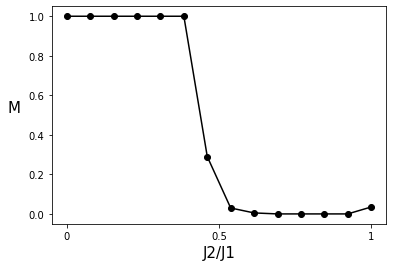

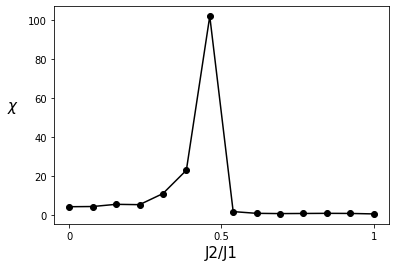

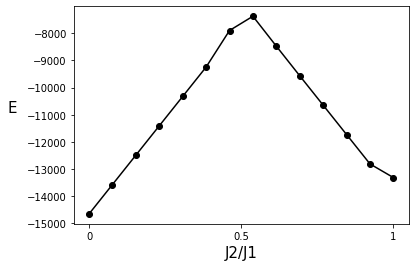

In [12]:
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).mag(mag_data_simul['OBC'])
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).sus()
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).ene(ene_data_simul['OBC'])

## 비교 (Raw QA 와 SA )

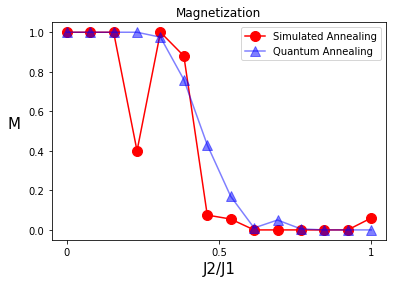

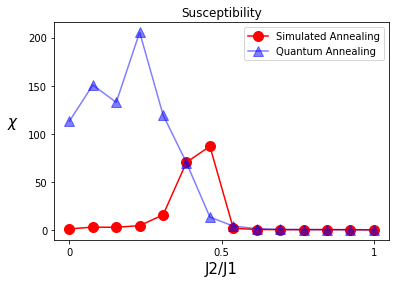

In [51]:
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).mag2(mag_data_simul['OBC'],'ro-','Simulated Annealing',marker_ = 10)
ploting(df_rr,'OBC',J2_interval_simul,L,num_shots,10).mag2(mag_data_rr['OBC'],'b^-','Quantum Annealing',alpha_=0.5,marker_ = 10)
plt.title("Magnetization")
plt.legend()
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).sus2('ro-','Simulated Annealing',marker_ = 10)
ploting(df_rr,'OBC',J2_interval_simul,L,num_shots,10).sus2('b^-','Quantum Annealing',alpha_=0.5,marker_ = 10)
plt.title("Susceptibility")
plt.legend()
plt.show()

## Quantum Annealing

In [17]:
with open('node_2000_obc.pickle','rb') as f:
    best_embedding = pickle.load(f)

In [18]:
start = time.time()
J1 = 10
L = 20
num_shots = 1000
J2_interval_tc = np.linspace(0,10,14)
response_tc = excutor_tc(num_shots,J2_interval_tc,best_embedding).Test('OBC',L,J1)
print("elapsed time is", time.time()- start)
print('-----------------------------------------------------')
response_tc_ = {x: response_tc for x in ['PBC','OBC']}
df_tc = go_pandas(response_tc_,J2_interval_tc,L).to_pandas()
ene_data_tc, mag_data_tc = go_pandas(response_tc_,J2_interval_tc,L).cal_more_infomation(J1,J2_interval_tc)

OBC Processing L =  20
100%|██████████| 14/14 [00:29<00:00,  2.11s/it]
elapsed time is 29.512044668197632
-----------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [00:09<00:00,  1.47it/s]
Processing for OBC
100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


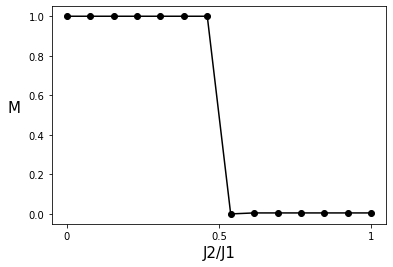

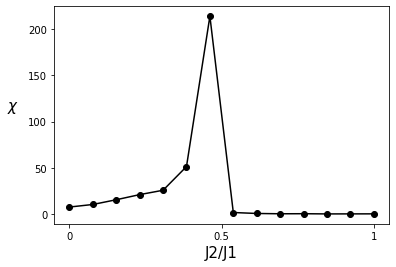

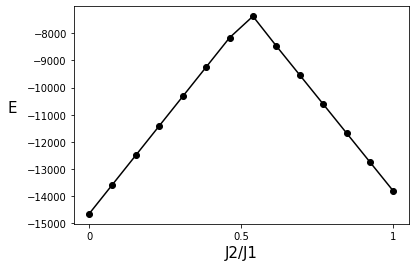

In [19]:
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).mag(mag_data_tc['OBC'])
plt.show()
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).sus()
plt.show()
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).ene(ene_data_tc['OBC'])

## 비교

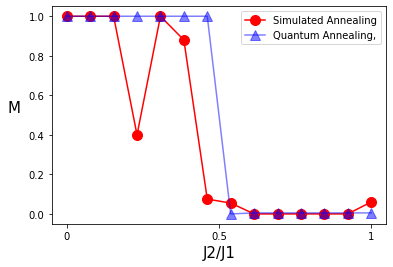

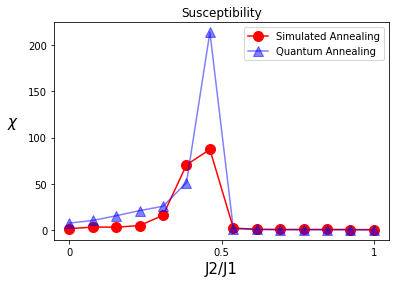

In [52]:
#def mag2(self,mag_list,feat,label_,alpha_=1,marker_ =5 ):
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).mag2(mag_data_simul['OBC'],'ro-','Simulated Annealing',marker_ = 10)
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).mag2(mag_data_tc['OBC'],'b^-','Quantum Annealing,',alpha_=0.5,marker_ = 10)
plt.legend()
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).sus2('ro-','Simulated Annealing',marker_ = 10)
ploting(df_tc,'OBC',J2_interval_simul,L,num_shots,10).sus2('b^-','Quantum Annealing',alpha_=1,marker_ = 10)
plt.title("Susceptibility")
plt.legend()
plt.show()

# L = 30

## Simulated Annealing

In [13]:
##simulation L = 30
L_30 = 30
J1_30 = 10
num_shots_30 = 1000
J2_interval_simul_30 = np.linspace(0,10,14)
start_30 = time.time()
response_simul_30 = excutor_simul(J2_interval_simul_30,num_shots_30).Test('OBC',L_30,J1_30)
print("[simulate annealing]\n elapsed time is ",time.time() - start)
print('-------------------------------------------------------------------')
response_simul_30 = {x: response_simul_30 for x in ['PBC','OBC']}
df_simul_30 = go_pandas(response_simul_30,J2_interval_simul_30,L_30).to_pandas()
ene_data_simul_30, mag_data_simul_30 = go_pandas(response_simul_30,J2_interval_simul_30,L_30).cal_more_infomation(J1_30,J2_interval_simul_30)

OBC Processing L =  30
100%|██████████| 14/14 [04:50<00:00, 20.74s/it]
[simulate annealing]
 elapsed time is  451.16522312164307
-------------------------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [00:19<00:00,  1.37s/it]
Processing for OBC
100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


In [1]:
ploting(df_simul_30,'OBC',J2_interval_simul_30,L_30,num_shots_30,J1_30).mag(mag_data_simul_30['OBC'])
plt.show()
ploting(df_simul_30,'OBC',J2_interval_simul_30,L_30,num_shots_30,J1_30).sus()
plt.show()
ploting(df_simul_30,'OBC',J2_interval_simul_30,L_30,num_shots_30,J1_30).ene(ene_data_simul_30['OBC'])

NameError: name 'ploting' is not defined

## Quantum Annealing

In [55]:
with open('best_embedding_100_L_30.pickle','rb') as f:
    best_embedding_30 = pickle.load(f)

In [56]:
start = time.time()
J1 = 10
L_30 = 30
num_shots = 1000
J2_interval_tc_30 = np.linspace(0,10,14)
response_tc_30 = excutor_tc(num_shots,J2_interval_tc_30,best_embedding_30).Test('OBC',L_30,J1)
print("elapsed time is", time.time()- start)
print('------------------------------------------------------')
response_tc_30 = {x: response_tc_30 for x in ['PBC','OBC']}
tc_30 = go_pandas(response_tc_30,J2_interval_tc_30,L_30).to_pandas()
ene_data_tc_30, mag_data_tc_30 = go_pandas(response_tc_30,J2_interval_tc_30,L_30).cal_more_infomation(J1,J2_interval_tc_30)

OBC Processing L =  30
100%|██████████| 14/14 [00:33<00:00,  2.38s/it]
elapsed time is 33.28342032432556
------------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [00:26<00:00,  1.87s/it]
Processing for OBC
100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


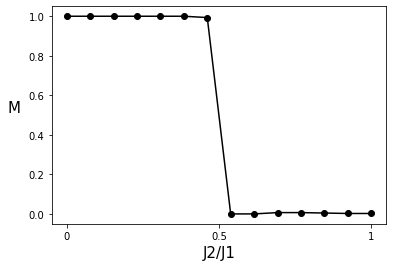

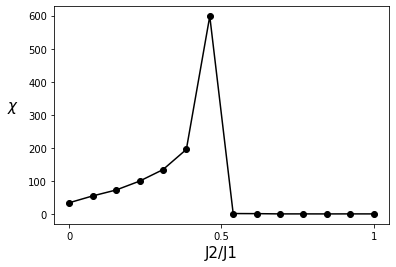

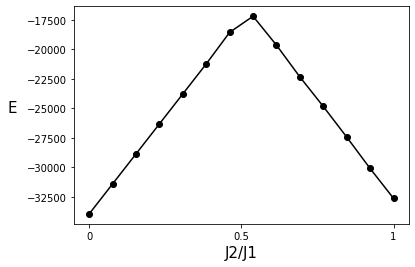

In [57]:
ploting(tc_30,'OBC',J2_interval_tc_30,L_30,num_shots,J1).mag(mag_data_tc_30['OBC'])
plt.show()
ploting(tc_30,'OBC',J2_interval_tc_30,L_30,num_shots,J1).sus()
plt.show()
ploting(tc_30,'OBC',J2_interval_tc_30,L_30,num_shots,J1).ene(ene_data_tc_30['OBC'])
plt.show()

## 비교

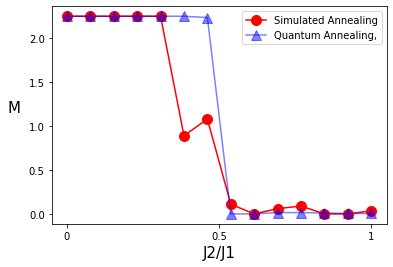

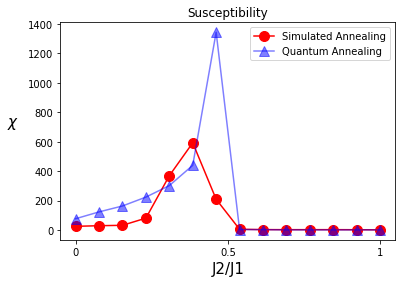

In [58]:
#def mag2(self,mag_list,feat,label_,alpha_=1,marker_ =5 ):
ploting(df_simul_30,'OBC',J2_interval_simul,L,num_shots,10).mag2(mag_data_simul_30['OBC'],'ro-','Simulated Annealing',marker_ = 10)
ploting(tc_30,'OBC',J2_interval_tc,L,num_shots,J1).mag2(mag_data_tc_30['OBC'],'b^-','Quantum Annealing,',alpha_=0.5,marker_ = 10)
plt.legend()
plt.show()
ploting(df_simul_30,'OBC',J2_interval_simul,L,num_shots,10).sus2('ro-','Simulated Annealing',marker_ = 10)
ploting(tc_30,'OBC',J2_interval_simul,L,num_shots,10).sus2('b^-','Quantum Annealing',alpha_=0.5,marker_ = 10)
plt.title("Susceptibility")
plt.legend()
plt.show()

# L =40 

## Simulated Annealing

In [59]:
##simulation L = 30
L_40 = 40
J1_40 = 10
num_shots_40 = 1000
J2_interval_simul_40 = np.linspace(0,10,14)
start_40 = time.time()
response_simul_40 = excutor_simul(J2_interval_simul_40,num_shots_40).Test('OBC',L_40,J1_40)
print("[simulate annealing]\n elapsed time is ",time.time() - start)
print('-------------------------------------------------------------------')
response_simul_40 = {x: response_simul_40 for x in ['PBC','OBC']}
df_simul_40 = go_pandas(response_simul_40,J2_interval_simul_40,L_40).to_pandas()
ene_data_simul_40, mag_data_simul_40 = go_pandas(response_simul_40,J2_interval_simul_40,L_40).cal_more_infomation(J1_40,J2_interval_simul_40)

OBC Processing L =  40
100%|██████████| 14/14 [08:13<00:00, 35.28s/it]
[simulate annealing]
 elapsed time is  597.8495132923126
-------------------------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [00:34<00:00,  2.48s/it]
Processing for OBC
100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


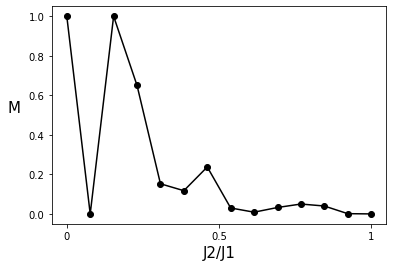

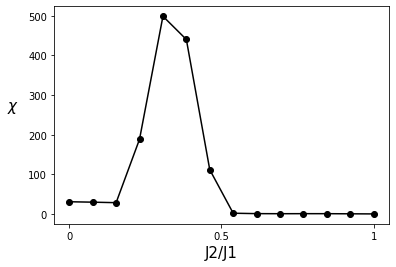

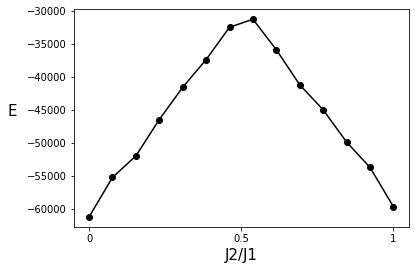

In [68]:
ploting(df_simul_40,'OBC',J2_interval_simul_40,L_40,num_shots_40,J1_40).mag(mag_data_simul_40['OBC'])
plt.show()
ploting(df_simul_40,'OBC',J2_interval_simul_40,L_40,num_shots_40,J1_40).sus()
plt.show()
ploting(df_simul_40,'OBC',J2_interval_simul_40,L_40,num_shots_40,J1_40).ene(ene_data_simul_40['OBC'])

## Quantum Annealing

In [61]:
with open('best_embedding_100_L_40.pickle','rb') as f:
    best_embedding_40 = pickle.load(f)

In [62]:
start = time.time()
J1 = 10
L_40 = 40
num_shots = 1000
J2_interval_tc_40 = np.linspace(0,10,14)
response_tc_40 = excutor_tc(num_shots,J2_interval_tc_40,best_embedding_40).Test('OBC',L_40,J1)
print("elapsed time is", time.time()- start)
print('------------------------------------------------------')
response_tc_40 = {x: response_tc_40 for x in ['PBC','OBC']}
tc_40 = go_pandas(response_tc_40,J2_interval_tc_40,L_40).to_pandas()
ene_data_tc_40, mag_data_tc_40 = go_pandas(response_tc_40,J2_interval_tc_40,L_40).cal_more_infomation(J1,J2_interval_tc_40)

OBC Processing L =  40
100%|██████████| 14/14 [00:40<00:00,  2.88s/it]
elapsed time is 40.37638282775879
------------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [00:39<00:00,  2.85s/it]
Processing for OBC
100%|██████████| 14/14 [00:39<00:00,  2.83s/it]


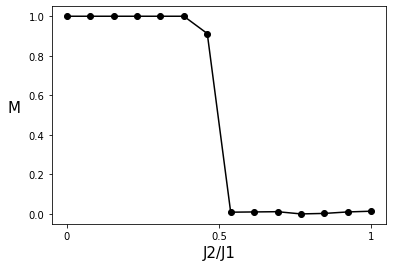

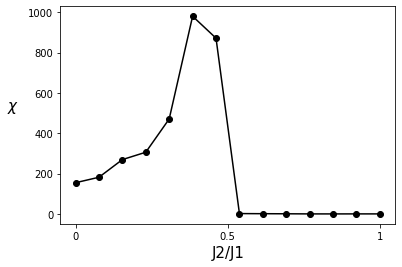

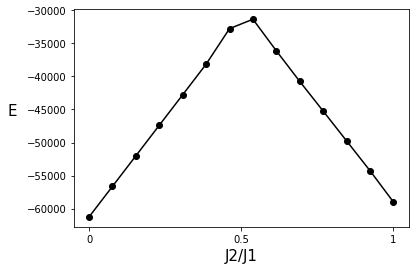

In [63]:
ploting(tc_40,'OBC',J2_interval_tc_40,L_40,num_shots,J1).mag(mag_data_tc_40['OBC'])
plt.show()
ploting(tc_40,'OBC',J2_interval_tc_40,L_40,num_shots,J1).sus()
plt.show()
ploting(tc_40,'OBC',J2_interval_tc_40,L_40,num_shots,J1).ene(ene_data_tc_40['OBC'])
plt.show()

## 비교

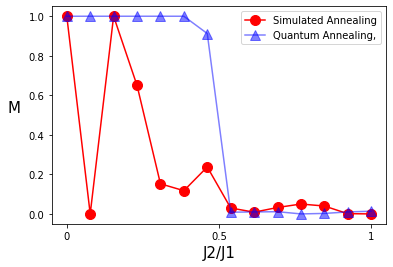

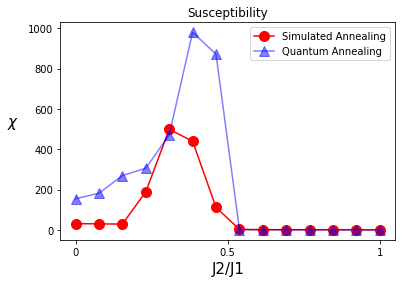

In [66]:
#def mag2(self,mag_list,feat,label_,alpha_=1,marker_ =5 ):
ploting(df_simul_40,'OBC',J2_interval_simul,L_40,num_shots,10).mag2(mag_data_simul_40['OBC'],'ro-','Simulated Annealing',marker_ = 10)
ploting(tc_40,'OBC',J2_interval_tc,L_40,num_shots,J1).mag2(mag_data_tc_40['OBC'],'b^-','Quantum Annealing,',alpha_=0.5,marker_ = 10)
plt.legend()
plt.show()
ploting(df_simul_40,'OBC',J2_interval_simul,L_40,num_shots,10).sus2('ro-','Simulated Annealing',marker_ = 10)
ploting(tc_40,'OBC',J2_interval_simul,L_40,num_shots,10).sus2('b^-','Quantum Annealing',alpha_=0.5,marker_ = 10)
plt.title("Susceptibility")
plt.legend()
plt.show()

# numshots = 10000 , simulated annealing | numshots = 1400 ,quantum annealing

## L = 20

In [17]:
##L = 20 
L = 20
J1 = 10
num_shots = 10000
J2_interval_simul = np.linspace(0,10,14)
start = time.time()
response_simul = excutor_simul(J2_interval_simul,num_shots).Test('OBC',L,J1)
print("[simulate annealing]\n elapsed time is ",time.time() - start)
print('-------------------------------------------------------------------')
response_simul = {x: response_simul for x in ['PBC','OBC']}
df_simul = go_pandas(response_simul,J2_interval_simul,L).to_pandas()
ene_data_simul, mag_data_simul = go_pandas(response_simul,J2_interval_simul,L).cal_more_infomation(J1,J2_interval_simul)

OBC Processing L =  20
100%|██████████| 14/14 [20:03<00:00, 85.96s/it]
[simulate annealing]
 elapsed time is  1203.5000925064087
-------------------------------------------------------------------
Processing for PBC
100%|██████████| 14/14 [01:43<00:00,  7.41s/it]
Processing for OBC
100%|██████████| 14/14 [01:45<00:00,  7.52s/it]


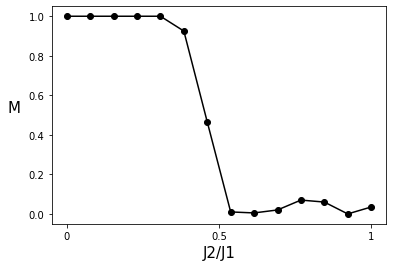

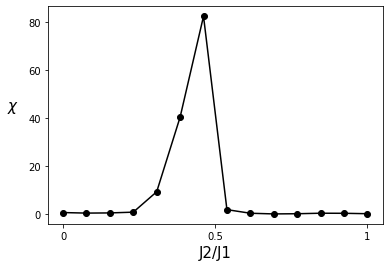

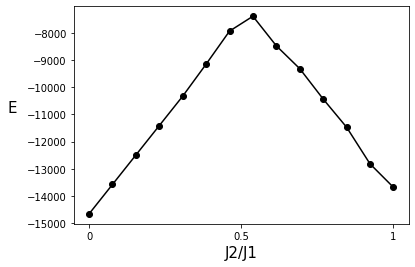

In [18]:
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).mag(mag_data_simul['OBC'])
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).sus()
plt.show()
ploting(df_simul,'OBC',J2_interval_simul,L,num_shots,10).ene(ene_data_simul['OBC'])

In [10]:
with open('node_2000_obc.pickle','rb') as f:
    best_embedding = pickle.load(f)

In [17]:
start = time.time()
J1 = 10
L = 20
num_shots = 1400
J2_interval_tc = np.linspace(0,10,14)
response_tc = excutor_tc(num_shots,J2_interval_tc,best_embedding).Test('OBC',L,J1)
print("elapsed time is", time.time()- start)
print('-----------------------------------------------------')
response_tc_ = {x: response_tc for x in ['PBC','OBC']}
df_tc = go_pandas(response_tc_,J2_interval_tc,L).to_pandas()
ene_data_tc, mag_data_tc = go_pandas(response_tc_,J2_interval_tc,L).cal_more_infomation(J1,J2_interval_tc)

OBC Processing L =  20
100%|██████████| 14/14 [00:31<00:00,  2.21s/it]
elapsed time is 31.02295970916748
-----------------------------------------------------


SolverFailureError: Problem not accepted because user heungsikim@kangwon.ac.kr has insufficient remaining solver access time in project yXwP

In [ ]:
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).mag(mag_data_tc['OBC'])
plt.show()
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).sus()
plt.show()
ploting(df_tc,'OBC',J2_interval_tc,L,num_shots,J1).ene(ene_data_tc['OBC'])

In [39]:
pip list

Note: you may need to restart the kernel to use updated packages.


# 소요시간 비교를 위한 L = 10 , 15,  25, 35 에서의 

In [40]:
print(neal.__version__)

0.5.9
